# Sentiment analysis
# Q2

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import re
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [6]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# selecting 10k observations

In [9]:
# selecting 10k rows
df = df.sample(n=10000, random_state=42)

In [10]:
# Shuffle the selected data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
df.head()

,review,sentiment
0,"the tortuous emotional impact is degrading, wh...",negative
1,Anyone who knows anything about evolution woul...,negative
2,I'm glad I rented this movie for one reason: i...,negative
3,"Yes, the votes are in. This film may very well...",negative
4,This mini-series is actually more entertaining...,negative


In [115]:
print("total rows in dataset are:",len(df))

total rows in dataset are: 10000


## preprocessing the data

In [13]:
df.isna().sum()
# there are no na values in the dataset

review       0
sentiment    0
dtype: int64

In [14]:
# Text Cleaning and Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters, punctuation, and symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenization and stopwords removal
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into text
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package stopwords to C:\Users\Saqib
[nltk_data]     siddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df['review'] = df['review'].apply(preprocess_text)

In [16]:
# lemmatising
df['review'] = df['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()

,review,sentiment
0,tortuous emotional impact degrading whether ad...,negative
1,anyone know anything evolution wouldnt even ne...,negative
2,im glad rented movie one reason shortcoming ma...,negative
3,yes vote film may well plan outer space genera...,negative
4,miniseries actually entertaining others much b...,negative


In [17]:
df['sentiment'].value_counts()

positive    5039
negative    4961
Name: sentiment, dtype: int64

## EDA

In [18]:
tf = df["review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.head()

,index,0
0,bad,3494.0
1,movie,19929.0
2,way,3352.0
3,emotional,244.0
4,sex,683.0


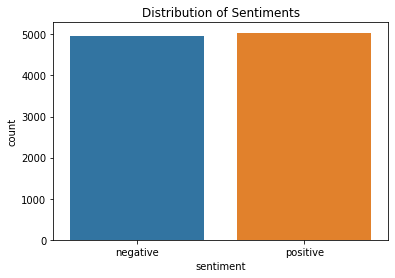

In [20]:
# Distribution of sentiment classes
import seaborn as sns
sns.countplot(data=df, x='sentiment')
plt.title('Distribution of Sentiments')
plt.show()

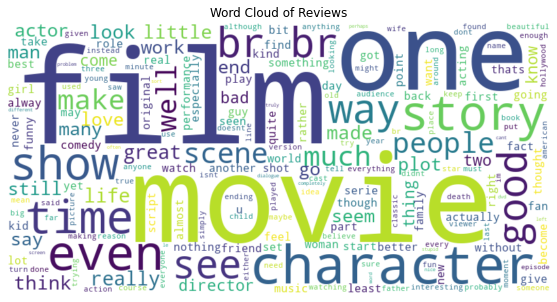

In [21]:
# Combine all reviews into one text
all_reviews = " ".join(df['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

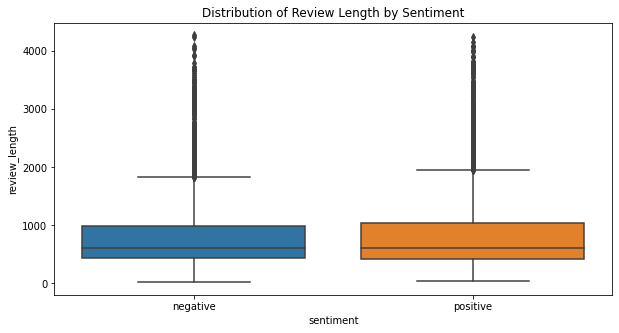

In [22]:
# Sentiment distribution based on review length
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='sentiment', y='review_length')
plt.title('Distribution of Review Length by Sentiment')
plt.show()

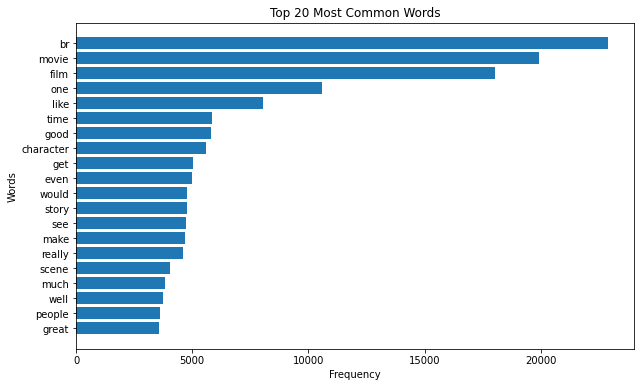

In [23]:
from collections import Counter

# Tokenize the reviews and count word frequencies
words = ' '.join(df['review']).split()
word_freq = Counter(words)

# Get the top N most common words
top_words = word_freq.most_common(20)

# Plot the word frequencies
plt.figure(figsize=(10, 6))
plt.barh([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words')
plt.gca().invert_yaxis()
plt.show()


## performing sentiment analysis

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

## drop the existing label column

In [100]:
df.drop(columns='sentiment',inplace=True)

In [26]:
df["review"][0:10].apply(lambda x: sid.polarity_scores(x))

0    {'neg': 0.518, 'neu': 0.317, 'pos': 0.164, 'co...
1    {'neg': 0.131, 'neu': 0.603, 'pos': 0.267, 'co...
2    {'neg': 0.188, 'neu': 0.596, 'pos': 0.216, 'co...
3    {'neg': 0.158, 'neu': 0.624, 'pos': 0.218, 'co...
4    {'neg': 0.014, 'neu': 0.763, 'pos': 0.223, 'co...
5    {'neg': 0.04, 'neu': 0.673, 'pos': 0.287, 'com...
6    {'neg': 0.0, 'neu': 0.668, 'pos': 0.332, 'comp...
7    {'neg': 0.165, 'neu': 0.591, 'pos': 0.244, 'co...
8    {'neg': 0.115, 'neu': 0.67, 'pos': 0.215, 'com...
9    {'neg': 0.033, 'neu': 0.577, 'pos': 0.39, 'com...
Name: review, dtype: object

In [27]:
df["review"][0:10].apply(lambda x: sid.polarity_scores(x)["compound"])

0   -0.9934
1    0.8335
2    0.1280
3    0.7506
4    0.9837
5    0.9763
6    0.8979
7    0.2960
8    0.9511
9    0.9726
Name: review, dtype: float64

## polarity score column

In [29]:
df["polarity_score"] = df["review"].apply(lambda x: sid.polarity_scores(x)["compound"])

In [101]:
df.head()

,review,review_length,polarity_score,sentiment_label
0,tortuous emotional impact degrading whether ad...,432,-0.9934,0
1,anyone know anything evolution wouldnt even ne...,399,0.8335,1
2,im glad rented movie one reason shortcoming ma...,585,0.1280,1
3,yes vote film may well plan outer space genera...,1021,0.7506,1
4,miniseries actually entertaining others much b...,995,0.9837,1


## adding sentiments from the scores we generated from SID

In [31]:
df["review"][0:10].apply(lambda x: "pos" if sid.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    pos
2    pos
3    pos
4    pos
5    pos
6    pos
7    pos
8    pos
9    pos
Name: review, dtype: object

In [32]:
df["sentiment_label"] = df["review"].apply(lambda x: "pos" if sid.polarity_scores(x)["compound"] > 0 else "neg")
df["sentiment_label"].value_counts()

pos    6932
neg    3068
Name: sentiment_label, dtype: int64

In [102]:
df.head()

,review,review_length,polarity_score,sentiment_label
0,tortuous emotional impact degrading whether ad...,432,-0.9934,0
1,anyone know anything evolution wouldnt even ne...,399,0.8335,1
2,im glad rented movie one reason shortcoming ma...,585,0.1280,1
3,yes vote film may well plan outer space genera...,1021,0.7506,1
4,miniseries actually entertaining others much b...,995,0.9837,1


In [34]:
# applying label encoder to the sentiment label
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [36]:
y = df["sentiment_label"]
X = df["review"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=70)

## applying models

In [38]:


# Linear Support Vector Classifier (LinearSVC)
text_clf_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SVC', LinearSVC())
])

# Multinomial Naive Bayes
text_clf_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('NB', MultinomialNB())
])

# Logistic Regression
text_clf_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('LR', LogisticRegression())
])

# Random Forest Classifier
text_clf_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('RF', RandomForestClassifier())
])

# Decision Tree Classifier
text_clf_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('DT', DecisionTreeClassifier())
])

# Gradient Boosting Classifier
text_clf_gb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('GB', GradientBoostingClassifier())
])

# K-Nearest Neighbors Classifier
text_clf_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('KNN', KNeighborsClassifier())
])


## multinomial Naive bayes

In [39]:
text_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('NB', MultinomialNB())])

In [40]:
# Form a prediction set
predictions_nb = text_clf_nb.predict(X_test)

In [41]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions_nb))

[[   0  923]
 [   0 2077]]


In [42]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       923
           1       0.69      1.00      0.82      2077

    accuracy                           0.69      3000
   macro avg       0.35      0.50      0.41      3000
weighted avg       0.48      0.69      0.57      3000



C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_nb))

0.6923333333333334


In [75]:
# printing f1 score
from sklearn.metrics import f1_score
f1_nb = f1_score(y_test, predictions_nb)
print(f1_nb)

0.8181997242466023


## SVC

In [44]:
text_clf_svc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SVC', LinearSVC())])

In [45]:
# Form a prediction set
predictions_svc = text_clf_svc.predict(X_test)

In [46]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions_svc))

[[ 624  299]
 [ 147 1930]]


In [47]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_svc))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       923
           1       0.87      0.93      0.90      2077

    accuracy                           0.85      3000
   macro avg       0.84      0.80      0.82      3000
weighted avg       0.85      0.85      0.85      3000



In [48]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_svc))

0.8513333333333334


In [76]:
# printing f1 score
from sklearn.metrics import f1_score
f1_svc = f1_score(y_test, predictions_svc)
print(f1_svc)

0.8964235949837436


## logistic regression

In [49]:
text_clf_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('LR', LogisticRegression())])

In [50]:
# Form a prediction set
predictions_lr = text_clf_lr.predict(X_test)

In [51]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions_lr))

[[ 447  476]
 [  67 2010]]


In [52]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_lr))

              precision    recall  f1-score   support

           0       0.87      0.48      0.62       923
           1       0.81      0.97      0.88      2077

    accuracy                           0.82      3000
   macro avg       0.84      0.73      0.75      3000
weighted avg       0.83      0.82      0.80      3000



In [53]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_lr))

0.819


In [77]:
# printing f1 score
from sklearn.metrics import f1_score
f1_lr = f1_score(y_test, predictions_lr)
print(f1_lr)

0.8809993425378041


## random forest classifier

In [54]:
text_clf_rf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('RF', RandomForestClassifier())])

In [55]:
# Form a prediction set
predictions_rf = text_clf_rf.predict(X_test)

In [56]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions_rf))

[[ 227  696]
 [  28 2049]]


In [57]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_rf))

              precision    recall  f1-score   support

           0       0.89      0.25      0.39       923
           1       0.75      0.99      0.85      2077

    accuracy                           0.76      3000
   macro avg       0.82      0.62      0.62      3000
weighted avg       0.79      0.76      0.71      3000



In [78]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_rf))

0.7586666666666667


In [79]:
# printing f1 score
from sklearn.metrics import f1_score
f1_rf = f1_score(y_test, predictions_rf)
print(f1_rf)

0.8498548320199087


## decision tree classifier

In [59]:
text_clf_dt.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('DT', DecisionTreeClassifier())])

In [60]:
# Form a prediction set
predictions_dt = text_clf_dt.predict(X_test)

In [61]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions_dt))

[[ 497  426]
 [ 512 1565]]


In [62]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_dt))

              precision    recall  f1-score   support

           0       0.49      0.54      0.51       923
           1       0.79      0.75      0.77      2077

    accuracy                           0.69      3000
   macro avg       0.64      0.65      0.64      3000
weighted avg       0.70      0.69      0.69      3000



In [63]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_dt))

0.6873333333333334


In [80]:
# printing f1 score
from sklearn.metrics import f1_score
f1_dt = f1_score(y_test, predictions_dt)
print(f1_dt)

0.7694198623402162


## Gradient boosting classifier

In [64]:
text_clf_gb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('GB', GradientBoostingClassifier())])

In [65]:
# Form a prediction set
predictions_gb = text_clf_gb.predict(X_test)

In [66]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions_gb))

[[ 418  505]
 [ 113 1964]]


In [67]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_gb))

              precision    recall  f1-score   support

           0       0.79      0.45      0.57       923
           1       0.80      0.95      0.86      2077

    accuracy                           0.79      3000
   macro avg       0.79      0.70      0.72      3000
weighted avg       0.79      0.79      0.78      3000



In [68]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_gb))

0.794


In [81]:
# printing f1 score
from sklearn.metrics import f1_score
f1_gb = f1_score(y_test, predictions_gb)
print(f1_gb)

0.864056313242411


## knn classifier

In [69]:
text_clf_knn.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('KNN', KNeighborsClassifier())])

In [70]:
# Form a prediction set
predictions_knn = text_clf_knn.predict(X_test)

C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [71]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions_knn))

[[ 380  543]
 [ 295 1782]]


In [72]:
# Print a classification report
print(metrics.classification_report(y_test,predictions_knn))

              precision    recall  f1-score   support

           0       0.56      0.41      0.48       923
           1       0.77      0.86      0.81      2077

    accuracy                           0.72      3000
   macro avg       0.66      0.63      0.64      3000
weighted avg       0.70      0.72      0.71      3000



In [73]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions_knn))

0.7206666666666667


In [82]:
# printing f1 score
from sklearn.metrics import f1_score
f1_knn = f1_score(y_test, predictions_knn)
print(f1_knn)

0.809631985461154


## getting scores of all models used

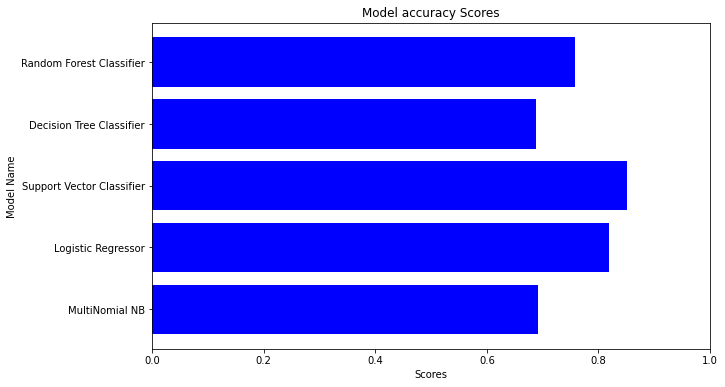

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the scores for each model
nb_score = text_clf_nb.score(X_test, y_test)
lr_score = text_clf_lr.score(X_test, y_test)
svc_score = text_clf_svc.score(X_test, y_test)
dc_score = text_clf_dt.score(X_test, y_test)
rf_score = text_clf_rf.score(X_test, y_test)

# Create a dictionary with model names and scores
scores = {
    'Model Name': ["MultiNomial NB", "Logistic Regressor", "Support Vector Classifier", "Decision Tree Classifier", "Random Forest Classifier"],
    'Scores': [nb_score, lr_score, svc_score, dc_score, rf_score]
}

# Create a DataFrame from the dictionary
scores_df = pd.DataFrame(scores)

# Plot the scores
plt.figure(figsize=(10, 6))
plt.barh(scores_df['Model Name'], scores_df['Scores'], color='blue')
plt.xlabel('Scores')
plt.ylabel('Model Name')
plt.title('Model accuracy Scores')
plt.xlim(0, 1)  # Set the x-axis limit to 0-1 for accuracy scores
plt.show()


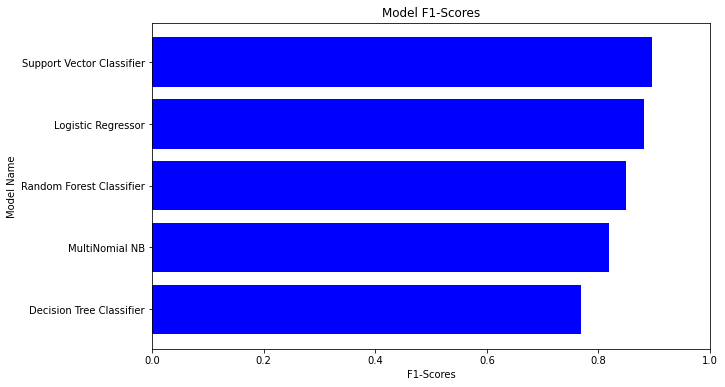

In [116]:
# Assuming you have already split your data into X_test and y_test
y_pred_nb = text_clf_nb.predict(X_test)
f1_nb = f1_score(y_test, y_pred_nb)

y_pred_lr = text_clf_lr.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr)

y_pred_svc = text_clf_svc.predict(X_test)
f1_svc = f1_score(y_test, y_pred_svc)

y_pred_dt = text_clf_dt.predict(X_test)
f1_dt = f1_score(y_test, y_pred_dt)

y_pred_rf = text_clf_rf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)

# Create a dictionary with model names and F1-scores
f1_scores = {
    'Model Name': ["MultiNomial NB", "Logistic Regressor", "Support Vector Classifier", "Decision Tree Classifier", "Random Forest Classifier"],
    'F1-Scores': [f1_nb, f1_lr, f1_svc, f1_dt, f1_rf]
}

# Create a DataFrame from the dictionary
f1_scores_df = pd.DataFrame(f1_scores)
f1_scores_df.sort_values(by='F1-Scores', inplace=True)

# Plot the F1-scores
plt.figure(figsize=(10, 6))
plt.barh(f1_scores_df['Model Name'], f1_scores_df['F1-Scores'], color='blue')
plt.xlabel('F1-Scores')
plt.ylabel('Model Name')
plt.title('Model F1-Scores')
plt.xlim(0, 1)  # Set the x-axis limit to 0-1 for F1-scores
plt.show()


#### SVC has the best f1-score

In [106]:
# positive review
my_review = "This movie was amazing, the plot and ending was soo good, i really enjoyed watching the movie, it is a MUST WATCH!!"
my_review = preprocess_text(my_review)
predicted_sentiment = text_clf_svc.predict([my_review])

In [107]:
# Interpret the result
if predicted_sentiment == 0:
    sentiment = "negative"
else:
    sentiment = "positive"

print(f"Predicted sentiment for your review: {sentiment}")

Predicted sentiment for your review: positive


In [108]:
sid.polarity_scores(my_review)

{'neg': 0.0, 'neu': 0.466, 'pos': 0.534, 'compound': 0.8832}

In [110]:
# negative review
my_neg_review = "The movie was an absolute disaster, it had no plot, no storyline and the actors were horrible"
my_review = preprocess_text(my_neg_review)
predicted_sentiment_neg = text_clf_svc.predict([my_neg_review])

In [111]:
# Interpret the result
if predicted_sentiment_neg == 0:
    sentiment = "negative"
else:
    sentiment = "positive"

print(f"Predicted sentiment for your review: {sentiment}")

Predicted sentiment for your review: negative


In [112]:
sid.polarity_scores(my_neg_review)

{'neg': 0.48, 'neu': 0.52, 'pos': 0.0, 'compound': -0.9001}